In [1]:
import numpy as np
import scipy.stats as sp
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')

#### Problem 1

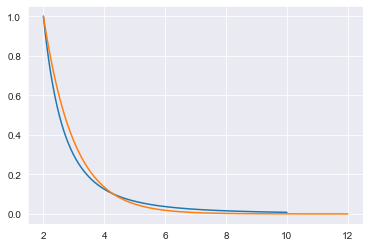

In [2]:
# plot the target density
x_plot = np.linspace(2,10,1000)
y_plot = 8/pow(x_plot,3)
sns.set_style('darkgrid')
ax_ = sns.lineplot(x=x_plot,y=y_plot)

# plot an exponential density shifted at 2
x_all = np.linspace(0,10,10000)
y_prop = sp.expon.pdf(x_all)
sns.lineplot(x=x_all+2,y=y_prop)

In [3]:
# function to do metropolis-hastings sampling
def metro_hast(f_pdf, g_pdf, g_gen,ndraws = 100,init_value = None, *args,**kwargs):
    ### function to run the general metropolis-hastings algorithm
    ### inputs
    ### f_pdf: a function that returns the pdf f(x)
    ### g_pdf: a function that returns the candidate value g(x_1|x_0)
    ### g_gen: a function that returns a random variable drawn from g(x_1|x_0)
    ### n_samples: the number of samples we want to generate from
    ### outputs
    ###----------------------------------------
    ###
    # following the text, initialize the initial samples
    # the first one is our initial
    sim_samples = g_gen(ndraws+1,*args,**kwargs)
    
    # allow for an initialization value 
    if init_value is not None:
        sim_samples[0]=init_value
        
    # we pull all the uniform variables we need upfront
    unif_rv = sp.uniform.rvs(size=ndraws)
    acceptance = np.zeros(ndraws)
    def accep_prob(x1,x0):
        if f_pdf(x0,x1) ==0:
            return 0.
        else:
            return f_pdf(x1,x0,*args,**kwargs)*g_pdf(x0,x1,*args,**kwargs)/(f_pdf(x0,x1,*args,**kwargs)*g_pdf(x1,x0,*args,**kwargs))

    for i_sim in range(1,len(sim_samples+1)):
        y = sim_samples[i_sim]
        x = sim_samples[i_sim-1]
        p_acc = min(1,accep_prob(y,x))
        sim_samples[i_sim] = x+(y-x)*(unif_rv[i_sim-1]<=p_acc)
        if unif_rv[i_sim-1]<=p_acc:
            acceptance[i_sim-1]=1
                
    results = {'samples':sim_samples,'accept_rate':acceptance.sum()/ndraws}
    return results

# getting the target and proposal densities
def f_target(x,*args,**kwargs):
    if x>2:
        return 8/pow(x,3)
    else:
        return 0

def g_exp_pdf(x,*args,**kwargs):
    # use an exponential distribution
    # because this distribution is iid the previous value has no bearing on the future
    # we subtract 2 since this is a shifted exponential
    return sp.expon.pdf(x-2)

def g_exp_gen(nobs,*args,**kwargs):
    # get shifted exponential values
    return sp.expon.rvs(size=nobs)+2

def g_logn_pdf(x,*args,**kwargs):
    return sp.lognorm.pdf(x,loc=2,s=1)

def g_logn_gen(nobs,*args,**kwargs):
    return sp.lognorm.rvs(loc=2,s=1,size=nobs)

In [12]:
test_logn = metro_hast(f_target,g_logn_pdf,g_logn_gen,ndraw=10000,)
test_exp = metro_hast(f_target,g_exp_pdf,g_exp_gen,ndraw=10000,)

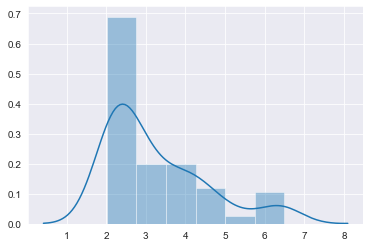

In [13]:
sns.distplot(test_exp['samples'])

#### Problem 3

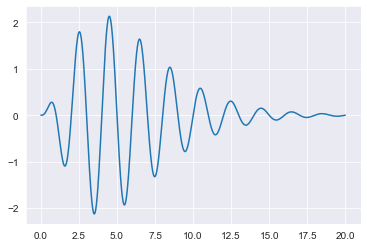

In [14]:
# first we plot the target integrand to see what it looks like
f_target = lambda x:pow(x,2)*np.sin(np.pi*x)*np.exp(-x/2)
x = np.linspace(0,20,10000)
sns.lineplot(x=x,y=f_target(x))

In [15]:
g_sample_exp = sp.expon.rvs(size=100000,scale=3,)
g_func_exp = lambda x: sp.expon.pdf(x,scale=3)

# calculating the integral
f_int_exp = np.mean(f_target(g_sample_exp)/g_func_exp(g_sample_exp))
print(f_int_exp)

-0.10392193397448818


In [16]:
g_sample_norm = sp.lognorm.rvs(size=100000,s=10,loc=0)
g_norm_func = lambda x: sp.lognorm.pdf(x,s=10,loc=0)
f_int_lnorm = np.mean(f_target(g_sample_norm)/g_norm_func(g_sample_norm))
print(f_int_lnorm)


-0.07477192668049341


Text(0, 0.5, 'f(x)')

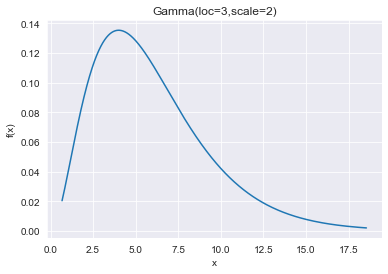

In [47]:
# plot a gamma function
dist_x = sp.gamma(a=3,scale=2)
x = dist_x.ppf(np.linspace(0.005,0.995,1000))
y = dist_x.pdf(x)
ax_3= sns.lineplot(x=x,y=y)
ax_3.set_title('Gamma(loc=3,scale=2)')
ax_3.set_xlabel('x')
ax_3.set_ylabel('f(x)')

In [17]:
# run integration with a gamma distribution
g_sample_gamma = sp.gamma(a=3,scale=2).rvs(size=100000)
g_gamma_func = lambda x: sp.gamma(a=3,scale=2).pdf(x,)
f_int_gamma = np.mean(f_target(g_sample_gamma)/g_gamma_func(g_sample_gamma))
print(f_int_gamma)


-0.03955854620329403


In [18]:
from scipy import integrate
f_int = integrate.quad(f_target, 0,np.inf,limit=100)
print(f_int[0])

-0.05529237717569376


### Problem 4a

In [20]:
# Problem 4
f_x = lambda x: 1/1+x
def mc_integral_unif(ffunc,n=10,antithetic=False,*args,**kwargs):
    dist_x = sp.uniform(loc=0,scale=1)
    # getting random variables
    xvar = dist_x.rvs(size=n)
    if antithetic:
        xvar_cdf = dist_x.cdf(xvar)
        xvar_anti = dist_x.ppf(1-xvar_cdf)
        print(np.corrcoef(xvar,xvar_anti))
        xvar = np.concatenate([xvar,xvar_anti])
    f_mean = np.mean(ffunc(xvar))
    f_var = np.var(ffunc(xvar))/len(xvar)
    
    results = pd.Series({'mean':f_mean,'var':f_var})
    return results

    

In [21]:
results_4a = mc_integral_unif(f_x,n=100)
print(results_4a)

mean    1.561671
var     0.000747
dtype: float64


In [22]:
results_4b = mc_integral_unif(f_x,n=100,antithetic=True)
print(results_4b)

[[ 1. -1.]
 [-1.  1.]]
mean    1.500000
var     0.000404
dtype: float64


### Problem 6

In [25]:
data = np.array([1.491,0.019,0.318,0.056,0.816,
                 0.978,0.174,0.461,0.495,0.547,
                 0.123,2.270,0.026,0.041,0.391])
prob_sample=(data<0.75).sum()/len(data)
print('Sample prob of x<0.75:  {0:.4f}'.format(prob_sample))

def bootstrap_6a(datavec,B=200,*args,**kwargs):
    # creating bootstrap for a problem 6a
    np.random.seed(100)
    b_samples= np.random.choice(datavec,size=(B,len(data)))
    # calculating probabilities
    b_prob =  (b_samples<0.75).sum(axis=1)/len(data)
    return b_prob


Sample prob of x<0.75:  0.7333


In [26]:
# getting results
results_6a = pd.Series(bootstrap_6a(datavec=data))
summ = pd.Series({'Mean': results_6a.mean(),'CL':results_6a.quantile(0.025),'CH':results_6a.quantile(0.975)})
print(summ)

Mean    0.745000
CL      0.533333
CH      0.933333
dtype: float64


In [43]:
def simulation_6b(B=200,K=100,n=15,*args,**kwargs):
    dist_rand = sp.uniform(loc=0,scale=1)
    sim_results = np.zeros(K,)
    #iterate through simulations
    for k_ in range(K):
        # set the seed so we can replicate the results
        np.random.seed(k_)
        # get a random draw from the uniform distribution
        sample_data = dist_rand.rvs(size=(n,))
        # run the same bootstrap we did for part (a)
        b_results = bootstrap_6a(datavec=sample_data)
        sim_results[k_] = b_results.mean()
    return sim_results

In [42]:
# run simulation and get results
results_6b = pd.Series(simulation_6b())
summ_6b = pd.Series({'mean': results_6b.mean(),'CL': results_6b.quantile(0.025),'CH': results_6b.quantile(0.975)})
print(summ_6b)

mean    0.761017
CL      0.557608
CH      0.941667
dtype: float64


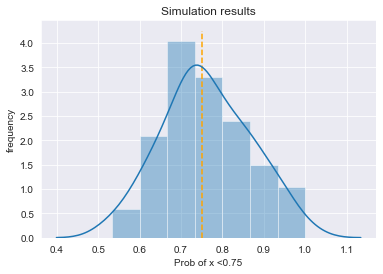

In [41]:
ax_6b = sns.distplot(results_6b)
ax_6b.set_title('Simulation results')
ax_6b.set_xlabel('Prob of x <0.75')
ax_6b.set_ylabel('frequency')
ax_6b.vlines(x=0.75,linestyle='--',ymin=0,ymax=ax_6b.get_ylim()[1],color='orange')
